## Agenda (8 March 2022)
1. What is Time-series data
2. Application of Time-series analysis 
3. Demonstration of Time-series analysis 

## What is a Time Series?

Time series is a sequence of observations recorded at regular time intervals. Depending on the frequency of observations, a time series may typically be hourly, daily, weekly, monthly, quarterly and annual. 

Time series are used in statistics, econometrics, mathematical finance, weather forecasting, and many other applications.

## Application of Time-series Analysis

**Reference Guide:**
[Applications of Time Series Analysis](https://www.analyticssteps.com/blogs/5-applications-time-series-analysis)

## ARIMA Model

**Reference Guide:**
[ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

## Project Objective
Build a time series model based on historical housing prices from Zillow and find out what are the <b>top 3 best zip codes</b> to invest in.

## Project Background

This project assumes to be an investment firm based in New York City to provide a detailed analysis and insights to investors who are interested in real estate for financial growth. The area we will be focusing on is **Brooklyn** and **Manhattan** zipcodes. 

**Project KPI:** 5 Yr ROI = ((House Price of Year 5 - Buy Price) / Buy Price)

## Step 1: Data pre-processing

In [ ]:
pip install --upgrade --no-deps statsmodels

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install patsy

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import itertools
import time
import random

#for data processing
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error

#for data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [ ]:
df = pd.read_csv('zillow_data.csv')

# Accessing the file from S3 bucket aws-carro-hackathon-workshop-pricing -> Only for AWS Notebook Instance
# df = pd.read_csv('s3://aws-carro-hackathon-workshop-pricing/zillow_data.csv')
# df.head()

# import boto3
# import io

# bucket='aws-carro-hackathon'
# file_key_1 = 'pricing/workshop/zillow_data.csv'

# # s3://aws-carro-hackathon/pricing/workshop/zillow_data.csv

# s3_client = boto3.client('s3')
# obj = s3_client.get_object(Bucket=bucket, Key=file_key_1)

# df = pd.read_csv(io.BytesIO(obj['Body'].read()))


print(f"DataFrame Shape: {df.shape}")
df.head()

DataFrame Shape: (14723, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
1,58197,1002,Amherst,MA,Springfield,Hampshire,4200,161000.0,160100.0,159300.0,...,333700,334800,336700,338900,340400,342000,344500,347400,350600,353300
2,58200,1005,Barre,MA,Worcester,Worcester,11214,103100.0,103400.0,103600.0,...,205600,206800,208800,210400,211300,213300,215600,217900,219500,220700
3,58201,1007,Belchertown,MA,Springfield,Hampshire,6851,133400.0,132700.0,132000.0,...,266100,266300,267000,267500,268000,268100,268100,268800,270000,270600
4,58202,1008,Blandford,MA,Springfield,Hampden,14548,117500.0,117300.0,117100.0,...,202400,202900,205900,208500,207500,205400,204500,206800,210900,214200


In [ ]:
area = pd.read_csv('manhattan_brooklyn_zip.csv')

# Accessing the file from S3 bucket aws-carro-hackathon-workshop-pricing -> Only for AWS Notebook Instance
# area = pd.read_csv('s3://aws-carro-hackathon-workshop-pricing/manhattan_brooklyn_zip.csv')
# area.head()

# file_key_2 = 'pricing/workshop/manhattan_brooklyn_zip.csv'

# # s3://aws-carro-hackathon/pricing/workshop/manhattan_brooklyn_zip.csv

# s3_client = boto3.client('s3')
# obj = s3_client.get_object(Bucket=bucket, Key=file_key_2)

# area = pd.read_csv(io.BytesIO(obj['Body'].read()))
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [ ]:
ny = df[(df['City'] == 'New York')]
print(f"DataFrame Shape (City = New York): {ny.shape}")
ny

DataFrame Shape (City = New York): (114, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1403,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
1404,61628,10014,New York,NY,New York,New York,509,NaN,NaN,NaN,...,9953900,9958800,9828700,9631000,9515800,9492800,9524900,9373400,9119600,8959300
1405,61635,10021,New York,NY,New York,New York,273,NaN,NaN,NaN,...,18889900,18703500,18605300,18569400,18428800,18307100,18365900,18530400,18337700,17894900
1406,61703,10128,New York,NY,New York,New York,22,3676700.0,3704200.0,3729600.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
1407,61777,10301,New York,NY,New York,Richmond,2215,175800.0,175500.0,175200.0,...,531500,539600,544900,543500,538900,536800,539300,542000,547300,552900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,62121,11435,New York,NY,New York,Queens,1558,136000.0,136300.0,136700.0,...,448500,453000,460500,465900,467500,468400,469500,471500,475800,480200
1633,62122,11436,New York,NY,New York,Queens,8009,119000.0,119400.0,119900.0,...,383800,382200,381000,382500,385600,387600,388700,390600,395100,400300
1669,62179,11691,New York,NY,New York,Queens,854,155700.0,156000.0,156300.0,...,443000,446900,449500,449500,445400,440100,437700,440300,449600,460300
1670,62180,11692,New York,NY,New York,Queens,6355,119400.0,119200.0,119300.0,...,322500,322000,325300,326600,327200,332300,336600,340600,349300,356700


In [ ]:
ny1 = pd.merge(ny, area, how='left', on='RegionName')
print(ny1.shape)
ny1

(114, 273)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
0,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300,Manhattan
1,61628,10014,New York,NY,New York,New York,509,NaN,NaN,NaN,...,9958800,9828700,9631000,9515800,9492800,9524900,9373400,9119600,8959300,Manhattan
2,61635,10021,New York,NY,New York,New York,273,NaN,NaN,NaN,...,18703500,18605300,18569400,18428800,18307100,18365900,18530400,18337700,17894900,Manhattan
3,61703,10128,New York,NY,New York,New York,22,3676700.0,3704200.0,3729600.0,...,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600,Manhattan
4,61777,10301,New York,NY,New York,Richmond,2215,175800.0,175500.0,175200.0,...,539600,544900,543500,538900,536800,539300,542000,547300,552900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,62121,11435,New York,NY,New York,Queens,1558,136000.0,136300.0,136700.0,...,453000,460500,465900,467500,468400,469500,471500,475800,480200,NaN
110,62122,11436,New York,NY,New York,Queens,8009,119000.0,119400.0,119900.0,...,382200,381000,382500,385600,387600,388700,390600,395100,400300,NaN
111,62179,11691,New York,NY,New York,Queens,854,155700.0,156000.0,156300.0,...,446900,449500,449500,445400,440100,437700,440300,449600,460300,NaN
112,62180,11692,New York,NY,New York,Queens,6355,119400.0,119200.0,119300.0,...,322000,325300,326600,327200,332300,336600,340600,349300,356700,NaN


In [ ]:
ny2 = ny1[ny1['District'].notnull()]
print(f"Brooklyn dataset: {ny2[ny2['District'] == 'Brooklyn'].shape}")
print(f"Manhattan dataset: {ny2[ny2['District'] == 'Manhattan'].shape}")

Brooklyn dataset: (29, 273)
Manhattan dataset: (4, 273)


Only 4 zipcodes in Manhattan are present in the database. We will focus on Brooklyn then.

In [ ]:
ny3 = ny2[ny2['District'] =='Brooklyn']
ny3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
36,62014,11203,New York,NY,New York,Kings,424,149000.0,149200.0,149400.0,...,454600,458800,462800,468700,474500,475300,474800,481000,489900,Brooklyn
37,62015,11204,New York,NY,New York,Kings,357,201100.0,201100.0,201100.0,...,932800,946200,953800,957100,958900,963200,967900,972800,976400,Brooklyn
38,62016,11205,New York,NY,New York,Kings,1435,NaN,NaN,NaN,...,2230800,2226800,2241400,2248400,2251000,2251600,2245300,2243700,2248400,Brooklyn
39,62019,11208,New York,NY,New York,Kings,309,126800.0,126700.0,126700.0,...,434400,437800,441600,440700,435400,429900,432300,442400,450600,Brooklyn
40,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn


In [ ]:
ny4 = ny3.drop(['RegionID','City','State','Metro','CountyName','SizeRank','District'], axis ='columns')
print(f"DataFrame Shape (District = Brooklyn): {ny4.shape}")
ny4 = ny4.sort_values(by=['RegionName'], ascending=True)
ny4

DataFrame Shape (District = Brooklyn): (29, 266)


,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
36,11203,149000.0,149200.0,149400.0,149600.0,149700.0,149900.0,150100.0,150400.0,150900.0,...,450900,454600,458800,462800,468700,474500,475300,474800,481000,489900
37,11204,201100.0,201100.0,201100.0,201100.0,201100.0,201300.0,201600.0,202000.0,202700.0,...,921200,932800,946200,953800,957100,958900,963200,967900,972800,976400
38,11205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2267400,2230800,2226800,2241400,2248400,2251000,2251600,2245300,2243700,2248400
39,11208,126800.0,126700.0,126700.0,126600.0,126600.0,126500.0,126400.0,126400.0,126500.0,...,432900,434400,437800,441600,440700,435400,429900,432300,442400,450600
40,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
41,11210,187300.0,187300.0,187200.0,187100.0,187000.0,186800.0,186800.0,186800.0,187100.0,...,777600,785800,792000,797600,800200,802900,809100,814500,816900,819600
42,11211,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,131800.0,132400.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700
43,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400
44,11214,191000.0,191200.0,191500.0,191900.0,192100.0,192400.0,192800.0,193200.0,193800.0,...,798000,805700,814200,820600,825000,826300,827600,830500,837300,844100
45,11215,225700.0,227500.0,229400.0,231600.0,234100.0,236900.0,239800.0,242900.0,246400.0,...,2173600,2201100,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900


In [ ]:
ny4[ny4['1996-04'].isnull()]['RegionName']

38    11205
47    11217
59    11231
64    11238
Name: RegionName, dtype: int64

Reshape from wide to long format & obtain mean housing price 

In [ ]:
def transform(dataframe):
    melted = pd.melt(dataframe, id_vars=['RegionName'], var_name='Month', value_name = 'MeanPrice')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanPrice'])
    return melted

In [ ]:
brooklyn_data = transform(ny4)
brooklyn_data.sort_values(by=['RegionName'],ascending = True)

,RegionName,Month,MeanPrice
0,11203,1996-04-01,149000.0
4756,11203,2009-12-01,349900.0
4785,11203,2010-01-01,348200.0
7250,11203,2017-02-01,450700.0
870,11203,1998-10-01,163800.0
...,...,...,...
4204,11238,2008-04-01,1285700.0
4233,11238,2008-05-01,1301000.0
4262,11238,2008-06-01,1308200.0
7307,11238,2017-03-01,2585200.0


In [ ]:
brooklyn_data.dtypes

RegionName             int64
Month         datetime64[ns]
MeanPrice            float64
dtype: object

In [ ]:
brooklyn_data.set_index('Month', inplace = True)

In [ ]:
#brooklyn_data = brooklyn_data.sort_values(by=['RegionName'],ascending = True).sort_index(ascending = True)
brooklyn_data

,RegionName,MeanPrice
Month,,
1996-04-01,11203,149000.0
1996-04-01,11204,201100.0
1996-04-01,11208,126800.0
1996-04-01,11209,255700.0
1996-04-01,11210,187300.0
...,...,...
2018-04-01,11233,852300.0
2018-04-01,11234,593300.0
2018-04-01,11235,816200.0


## Step 2: Data Exploration and Visualization

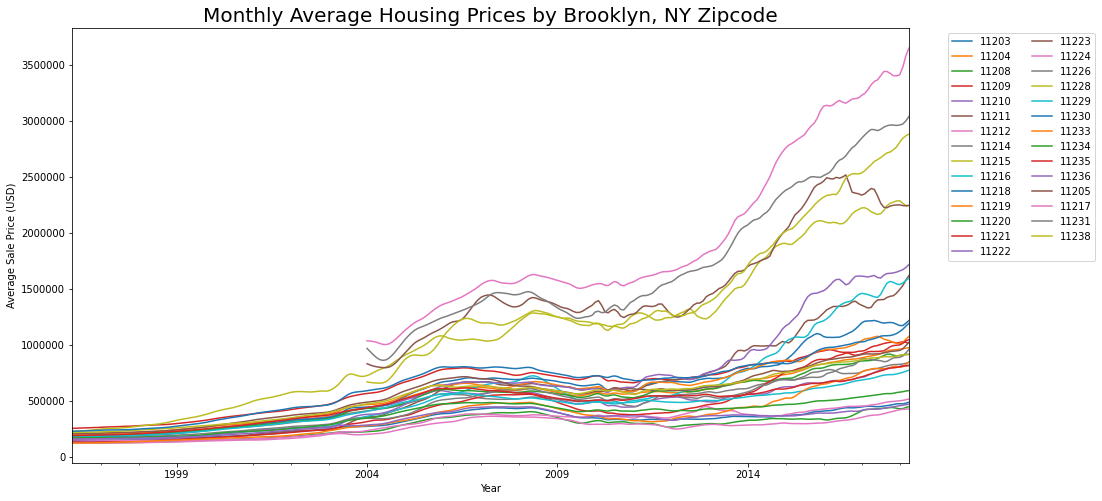

In [ ]:
for zipcode in brooklyn_data.RegionName.unique():
    temp_df = brooklyn_data[brooklyn_data.RegionName == zipcode]
    temp_df['MeanPrice'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Year")
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20)
plt.show()

**Observations of the data:**
- 25 zip codes have data from 1996 to 2018
- 4 zip codes (11205, 11217, 11231, 11238) has missing data from 1996 to 2014
- Hence, data before 2004 is not considered further.


Therefore, we shall take a deeper look into the data from 2004 onwards.

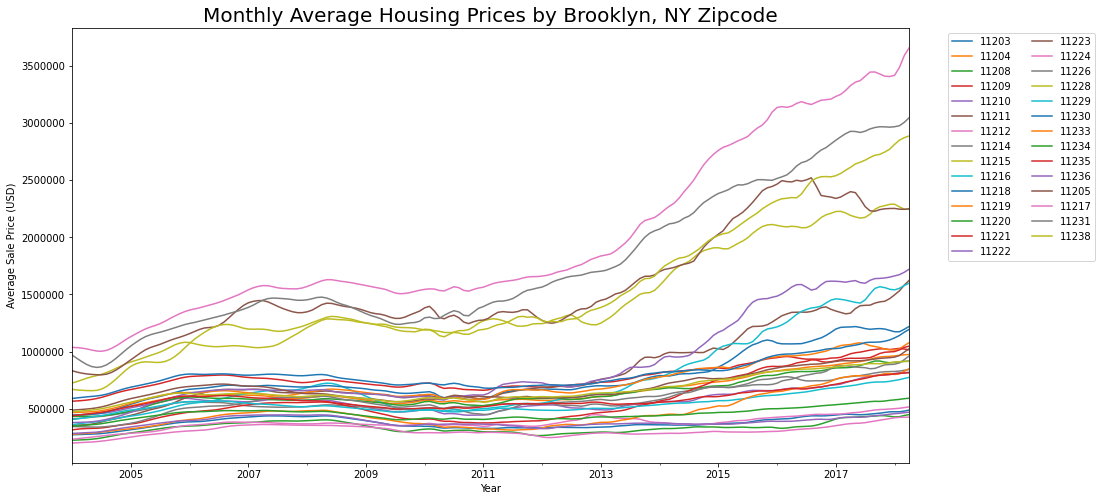

In [ ]:
#A deeper look from 2004 above
for zipcode in brooklyn_data.RegionName.unique():
    temp_df = brooklyn_data[brooklyn_data.RegionName == zipcode]
    temp_df['2004':]['MeanPrice'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Year")
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);

**Observations of the data:**
- There was a dip in 2008 and 2010 because of the financial crisis, housing price became stable around 2011.
- To get more accurate predictions on the year 2020 and above data, we have decided to use data ranging from 2011-Present.

In [ ]:
df2011 = brooklyn_data['2011':]
month_avg = df2011.groupby('Month')['MeanPrice'].mean()
month_avg = pd.DataFrame(data = month_avg)
month_avg

,MeanPrice
Month,
2011-01-01,6.333655e+05
2011-02-01,6.383345e+05
2011-03-01,6.473586e+05
2011-04-01,6.554655e+05
2011-05-01,6.599552e+05
...,...
2017-12-01,1.209862e+06
2018-01-01,1.215266e+06
2018-02-01,1.224759e+06


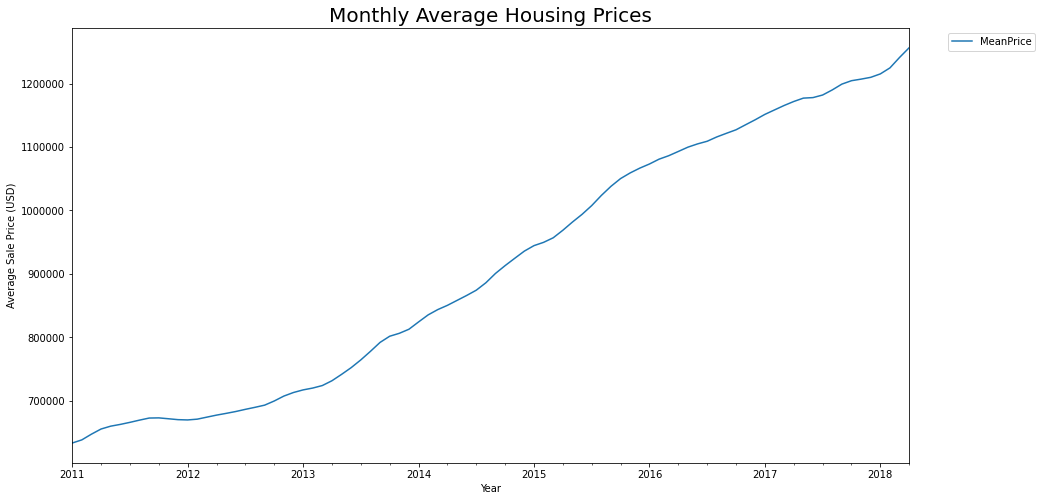

In [ ]:
month_avg.plot(figsize = (15,8), label= 'MeanPrice')

plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Year")
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices', fontsize = 20)
plt.show()

### Seasonal Decomposition for 2011 and Above
Let's see if there was seasonal effect on house price.

**References:** <br>
- [How to Decompose Time Series Data into Trend and Seasonality](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

- [Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

- Trend: The increasing or decreasing value in the dataset.
- Seasonality: The repeating short-term cycle in the dataset.
- Residual / noise : The random variation in the dataset which remains behind when separate seasonality and trend from the time series

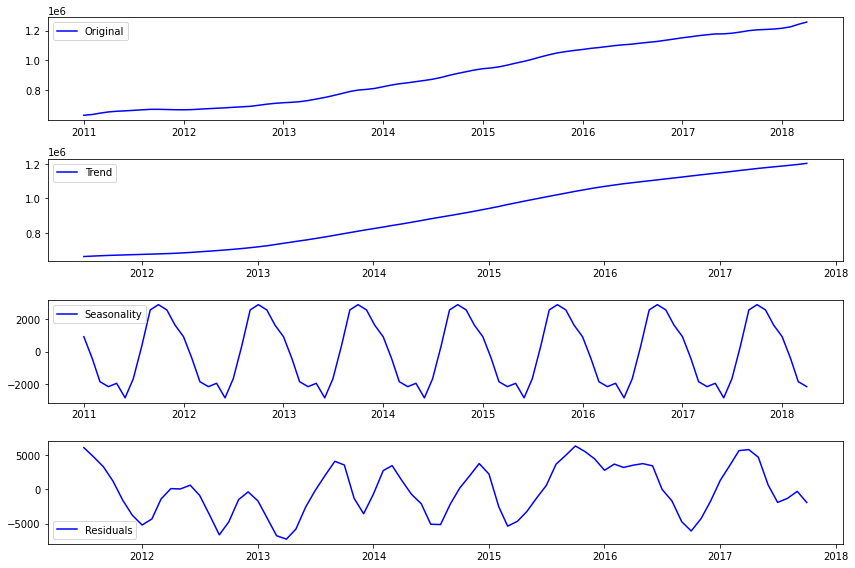

In [ ]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(month_avg, label='Original', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

**Observations of the data:**
- An upward trend is present with yearly seasonal changes.
- Look into residual.

**Dickey Fuller test**

- Dickey Fuller test is used to test stationarity. The null hypothesis is time series is non-stationary, and the alternative hypothesis is time series is stationarary.

**References:**
[Augmented Dickey Fuller Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

In [ ]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=12, center=False).mean()
    roll_std = TS.rolling(window=12, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

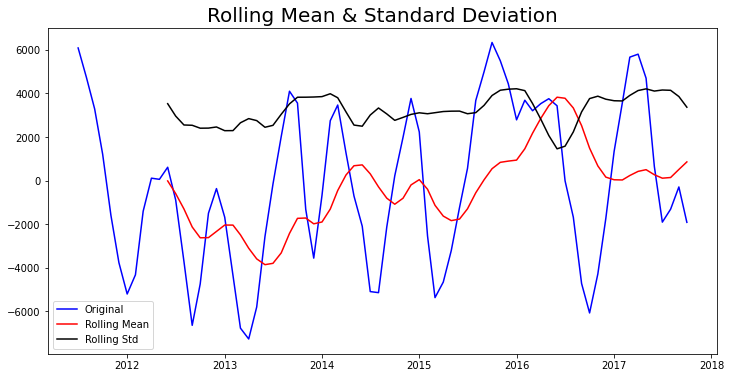

Results of Dickey-Fuller Test: 

Test Statistic                 -2.527008
p-value                         0.109040
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [ ]:
stationarity_check(ts_log_decompose)

**Observations of the data:**
- Mean and standard deviation are not stationary
- The p-value (0.109040) is larger than significance level (0.05). We can accept the null which means the residuals are not stationary.

### Autocorrelation Function (ACF) & Partial Autocorrelation Function (PCF)

- ACF: The correlation between two values in a time series.
- Lag: The number of intervals between the two observations.
- PCF: similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain. For example, the partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain. 
<br>

**Reference Guide:** 
- [Autocorrelation and Partial Autocorrelation in Time Series Data](https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/)
- [Choosing the best q and p from ACF and PACF plots in ARMA-type modeling](https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling)

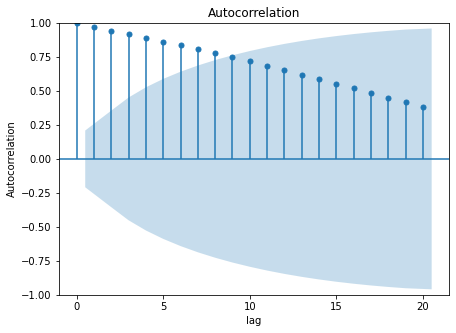

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


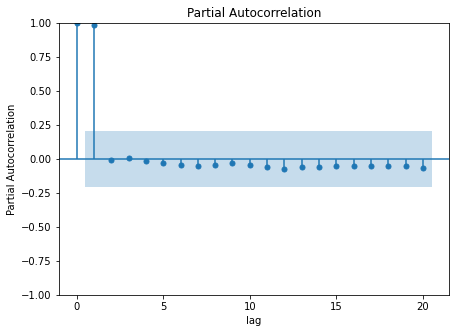

In [ ]:
rcParams['figure.figsize'] = 7,5
plot_acf(month_avg) 
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
# plt.xlim(0,24)
plt.show()

plot_pacf(month_avg)
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
# plt.xlim(0, 24)
plt.ylim(-1, 1)
plt.show()

#### If take lag = 3 difference. Autocorrelation appears.

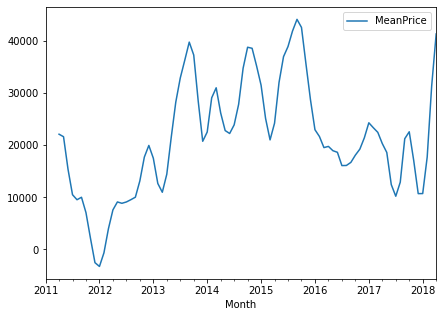

In [ ]:
rcParams['figure.figsize'] = 7,5
month_avg.diff(periods=3).plot();

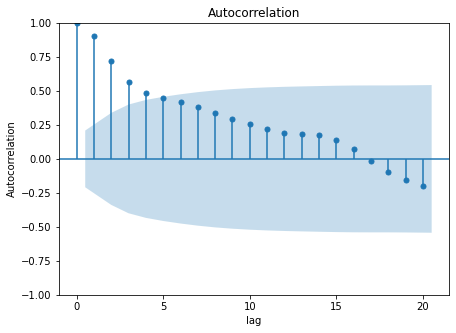

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


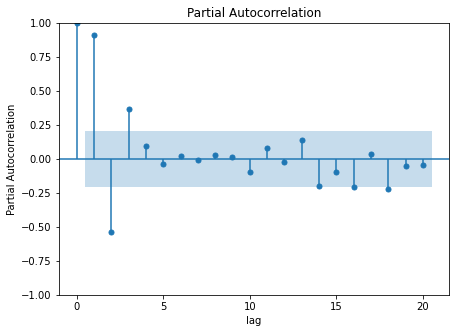

In [ ]:
rcParams['figure.figsize'] = 7,5
plot_acf(month_avg.diff(periods=3).bfill())
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
# plt.xlim(0, 24)
plt.show()

plot_pacf(month_avg.diff(periods=3).bfill())
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
# plt.xlim(0, 24)
plt.ylim(-1,1)
plt.show()

## Step 3: Initial SARIMA Models on Sample Zip Codes

Perform SARIMA model on 3 sample zip codes.

In [ ]:
brooklyn_data.RegionName.unique()

array([11203, 11204, 11208, 11209, 11210, 11211, 11212, 11214, 11215,
       11216, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11226,
       11228, 11229, 11230, 11233, 11234, 11235, 11236, 11205, 11217,
       11231, 11238])

In [ ]:
#Randomly select 3 zipcodes
zip_dfs = []
zip_list = random.choices(brooklyn_data.RegionName.unique(), k=3)
print(zip_list)

[11215, 11205, 11214]


In [ ]:
for x in zip_list:
    zip_dfs.append(pd.DataFrame(brooklyn_data[brooklyn_data['RegionName'] == x][['MeanPrice']].copy()))
    
zip_dfs

[            MeanPrice
 Month                
 1996-04-01   225700.0
 1996-05-01   227500.0
 1996-06-01   229400.0
 1996-07-01   231600.0
 1996-08-01   234100.0
 ...               ...
 2017-12-01  2287100.0
 2018-01-01  2288900.0
 2018-02-01  2265300.0
 2018-03-01  2244900.0
 2018-04-01  2243900.0
 
 [265 rows x 1 columns],
             MeanPrice
 Month                
 2004-01-01   833100.0
 2004-02-01   821400.0
 2004-03-01   812000.0
 2004-04-01   805500.0
 2004-05-01   801400.0
 ...               ...
 2017-12-01  2251000.0
 2018-01-01  2251600.0
 2018-02-01  2245300.0
 2018-03-01  2243700.0
 2018-04-01  2248400.0
 
 [172 rows x 1 columns],
             MeanPrice
 Month                
 1996-04-01   191000.0
 1996-05-01   191200.0
 1996-06-01   191500.0
 1996-07-01   191900.0
 1996-08-01   192100.0
 ...               ...
 2017-12-01   826300.0
 2018-01-01   827600.0
 2018-02-01   830500.0
 2018-03-01   837300.0
 2018-04-01   844100.0
 
 [265 rows x 1 columns]]

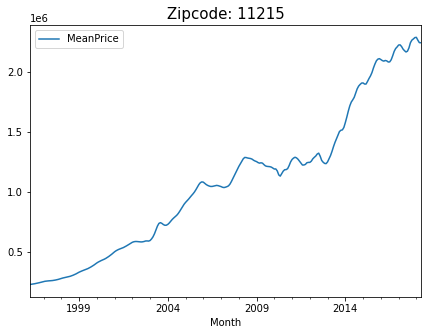

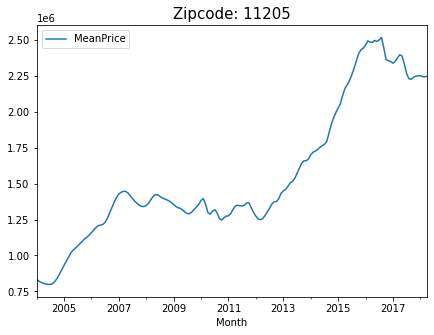

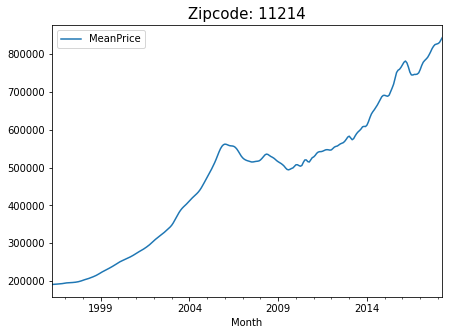

In [ ]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(f"Zipcode: {name}", fontsize=15)
    plt.show()

An ARIMA model is characterized by 3 terms: p, d, q

*   p is the order of the AR term
*   q is the order of the MA term
*   d is the number of differencing required to make the time series stationary


Seasonality
- For monthly data, S = 12 (months per year)
- For quarterly data, S = 4 (time periods per year)

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


**References:** 
- [SARIMAX](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
- [frequency information](https://stackoverflow.com/questions/49547245/valuewarning-no-frequency-information-was-provided-so-inferred-frequency-ms-wi)

In [ ]:
#Run SARIMA Model (Kindly note that this might take some time to run)
start = time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, 
                                                                                                     para2, 
                                                                                                     output.aic))
            except:
                continue

Result for 11215 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8156.852368376425
Result for 11215 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7631.574154397393
Result for 11215 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6677.9210476668495
Result for 11215 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6302.364443322858
Result for 11215 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6548.1363943604665
Result for 11215 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6512.766064559078
Result for 11215 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6284.281239526274
Result for 11215 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6233.570372442373
Result for 11215 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7934.540644584911
Result for 11215 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7529.638405474563
Result for 11215 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6758.646421083669
Result for 11215 ARIMA (0, 0, 

In [ ]:
print('Took', time.time()-start, 'seconds.')

Took 44.908145904541016 seconds.


The **Akaike Information Critera (AIC)** is a widely used measure of a statistical model. It basically quantifies: <br> 
1) the goodness of fit <br>
2) the simplicity/parsimony of the model into a single statistic

When comparing two models, the one with the lower AIC is generally “better”.

In [ ]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
result

,name,pdq,pdqs,AIC
0,11215,"(0, 0, 0)","(0, 0, 0, 12)",8156.852368
1,11215,"(0, 0, 0)","(0, 0, 1, 12)",7631.574154
2,11215,"(0, 0, 0)","(0, 1, 0, 12)",6677.921048
3,11215,"(0, 0, 0)","(0, 1, 1, 12)",6302.364443
4,11215,"(0, 0, 0)","(1, 0, 0, 12)",6548.136394
...,...,...,...,...
187,11214,"(1, 1, 1)","(0, 1, 1, 12)",4346.326118
188,11214,"(1, 1, 1)","(1, 0, 0, 12)",4419.026860
189,11214,"(1, 1, 1)","(1, 0, 1, 12)",4406.821652
190,11214,"(1, 1, 1)","(1, 1, 0, 12)",4399.727489


In [ ]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
best_para

,name,pdq,pdqs,AIC
127,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
187,11214,"(1, 1, 1)","(0, 1, 1, 12)",4346.326118
63,11215,"(1, 1, 1)","(1, 1, 1, 12)",4954.014040


In [ ]:
# Mean house price in Brooklyn is above $1 Million
meanBrooklyn = brooklyn_data['2017':]['MeanPrice'].mean()
print(f"Mean House Price in Brooklyn from 2017 onwards: ${round(meanBrooklyn, 2)}")

Mean House Price in Brooklyn from 2017 onwards: $1195787.93


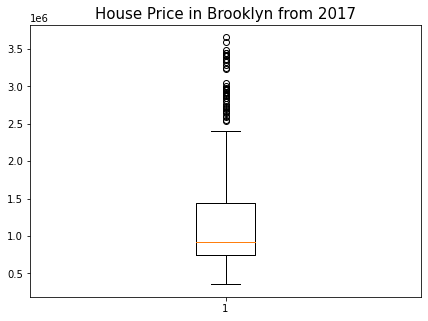

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('House Price in Brooklyn from 2017', fontsize=15)
ax1.boxplot(brooklyn_data['2017':]['MeanPrice']);

#### Plug the optimal parameter values into a new SARIMAX model to have a deeper look

**References:** [Interpreting ARMA model results in Statsmodels for absolute beginners](https://medium.com/analytics-vidhya/interpreting-arma-model-results-in-statsmodels-for-absolute-beginners-a4d22253ad1c)

In [ ]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary())
    #print(output.summary().tables[1])

SARIMA Model Result for 11205
                                     SARIMAX Results                                      
Dep. Variable:                          MeanPrice   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2472.007
Date:                            Tue, 08 Mar 2022   AIC                           4954.014
Time:                                    06:33:03   BIC                           4971.375
Sample:                                04-01-1996   HQIC                          4961.011
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7323      0.043     16.995      0.000       0.648       0.817
ma.L1

#### Make dynamic forecast using data from 2017-01-01 onwards and compare with real values post 2017-01-01

**Reference Guide:**
[`conf_int`](https://www.kite.com/python/docs/statsmodels.tsa.ar_model.ARResultsWrapper.conf_int)

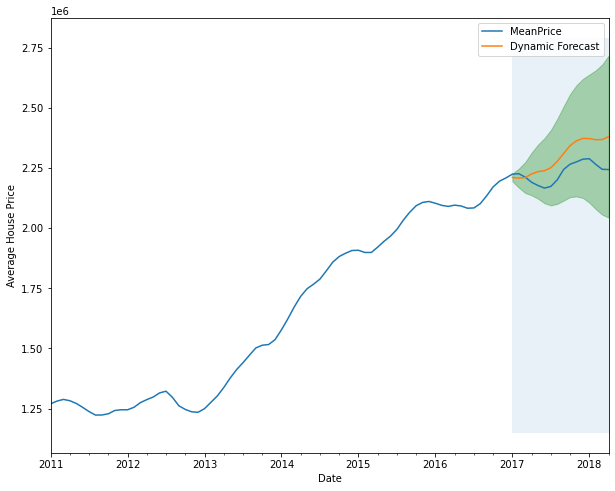

The Mean Squared Error of our forecasts is 78750.3


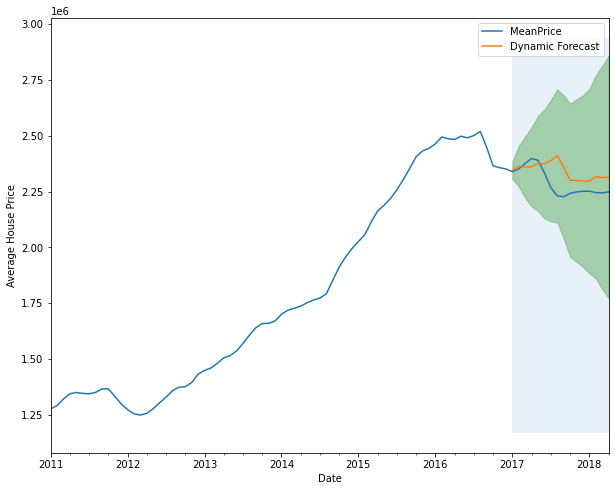

The Mean Squared Error of our forecasts is 76026.77


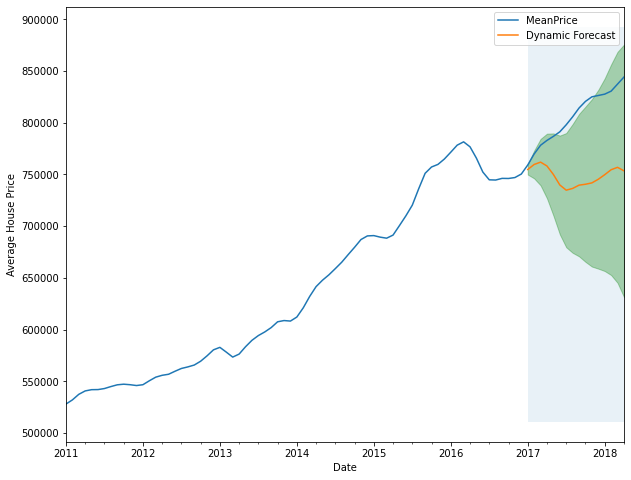

The Mean Squared Error of our forecasts is 64092.84


In [ ]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-01-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanPrice']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['RMSE'] = MSE_Value

In [ ]:
summary_table

,Zipcode,RMSE
0,11205,78750.299577
1,11214,76026.766815
2,11215,64092.839534


#### Producing and Visualizing Forecasts

In [ ]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]

for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    
    current.append(df['2018-04']['MeanPrice'][0])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  from ipykernel import kernelapp as app


In [ ]:
forecast_table

,Zipcode,Current Value,3 Years Value,5 Years Value,3Yr-ROI,5Yr-ROI
0,11205,2243900.0,2.557550e+06,2.756927e+06,0.139779,0.228632
1,11214,2248400.0,1.826419e+06,1.547083e+06,-0.187680,-0.311918
2,11215,844100.0,1.024755e+06,1.143259e+06,0.214021,0.354412


## Step 4: Run SARIMA models on all Zipcodes

Iterate through all zipcodes.

In [ ]:
zip_dfs = []
zip_list = brooklyn_data.RegionName.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(brooklyn_data[brooklyn_data['RegionName']==x][['MeanPrice']].copy()))

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
#Run SARIMA Model (Kindly note that this might take some time to run)
ans = []
start = time.time()

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, 
                                                                                                     para2, 
                                                                                                     output.aic))
            except:
                continue

Result for 11203 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7459.8192830201615
Result for 11203 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 282876.59716580814
Result for 11203 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5937.5872868449005
Result for 11203 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5667.677896143193
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5915.665653276429
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5857.548269113351
Result for 11203 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5534.032764342531
Result for 11203 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7216.504823655787
Result for 11203 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 32292.280017055054
Result for 11203 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 288144.4951168304
Result for 11203 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5748.370809131386
Result for 11203 ARIMA (0, 0

In [ ]:
print('Took', time.time()-start, 'seconds.')

Took 471.8359708786011 seconds.


In [ ]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [ ]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [ ]:
best_para.head()

,name,pdq,pdqs,AIC
63,11203,"(1, 1, 1)","(1, 1, 1, 12)",4180.766192
123,11204,"(1, 1, 1)","(0, 1, 1, 12)",4286.602865
1663,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
191,11208,"(1, 1, 1)","(1, 1, 1, 12)",4250.901034
255,11209,"(1, 1, 1)","(1, 1, 1, 12)",4585.735786


In [ ]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])

SARIMA Model Result for 11203
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8087      0.046     17.612      0.000       0.719       0.899
ma.L1          0.3367      0.026     13.060      0.000       0.286       0.387
ar.S.L12      -0.4887      0.064     -7.620      0.000      -0.614      -0.363
ma.S.L12      -0.0346      0.041     -0.838      0.402      -0.116       0.046
sigma2      2.616e+06   1.61e+05     16.211      0.000     2.3e+06    2.93e+06
SARIMA Model Result for 11204
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7490      0.042     18.026      0.000       0.668       0.830
ma.L1          0.6234      0.040     15.397      0.000       0.544       0.703
ma.S.L12      -0.2088      0.026     -7.939      0.000      -0.260     

#### Make dynamic forecast from 2017-01-01 onwards and compare with real values

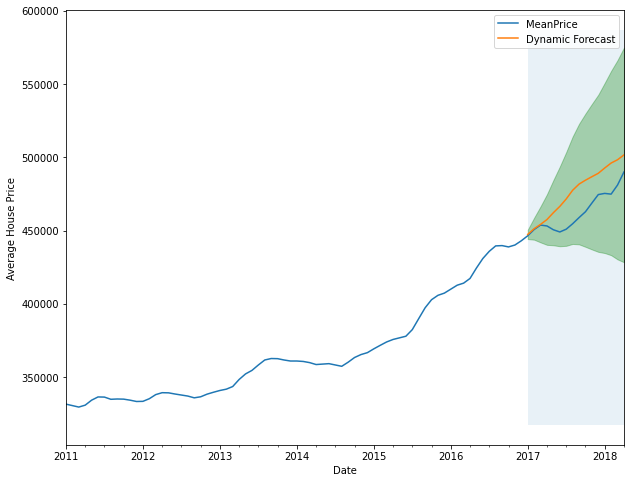

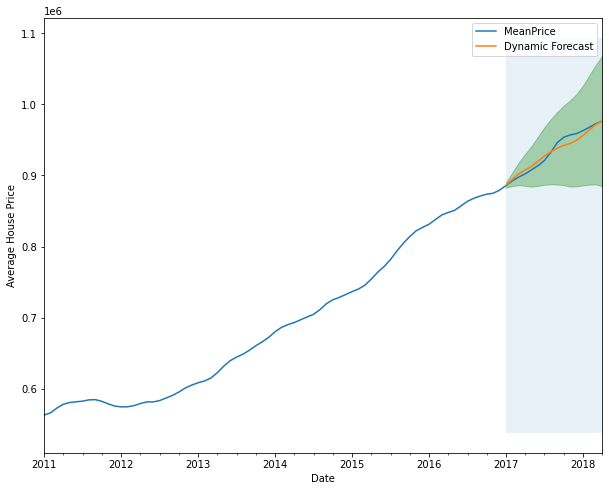

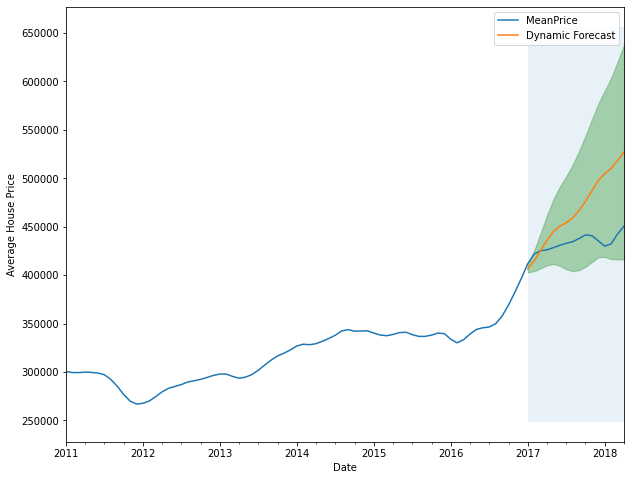

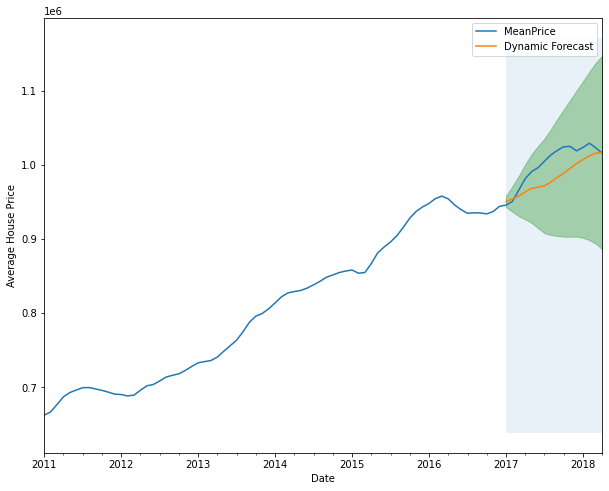

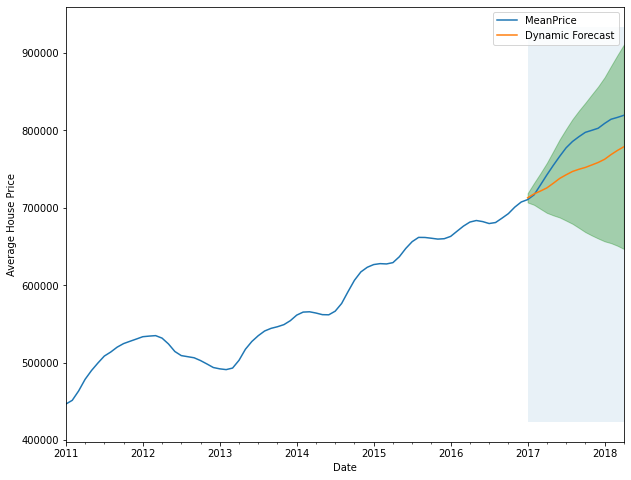

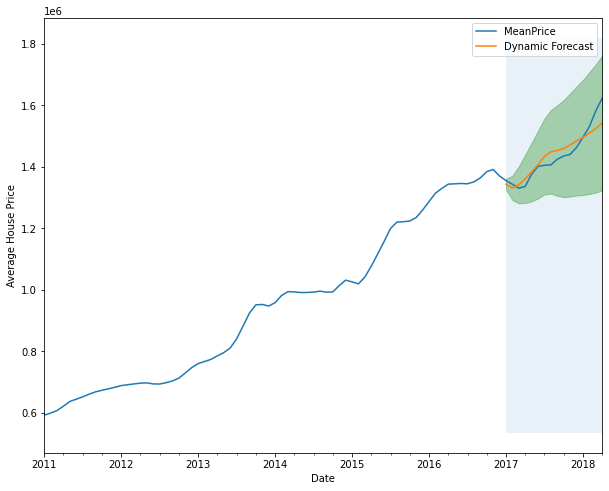

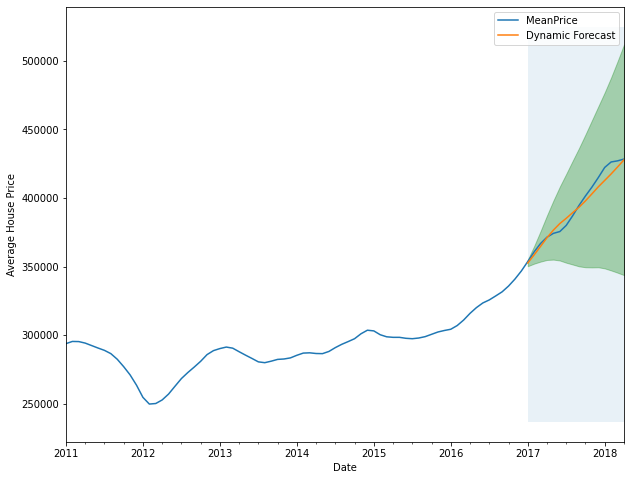

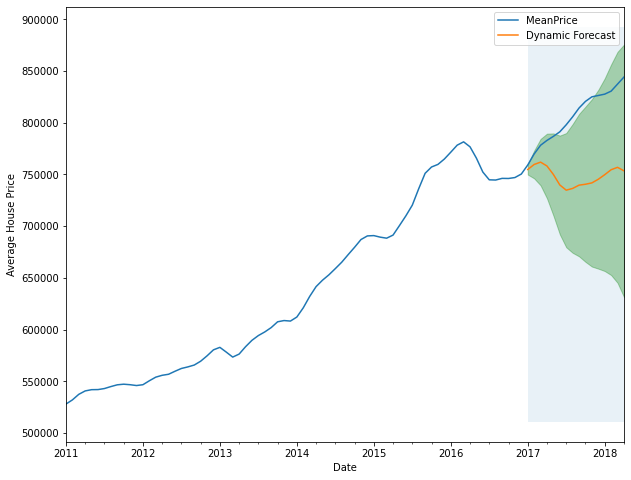

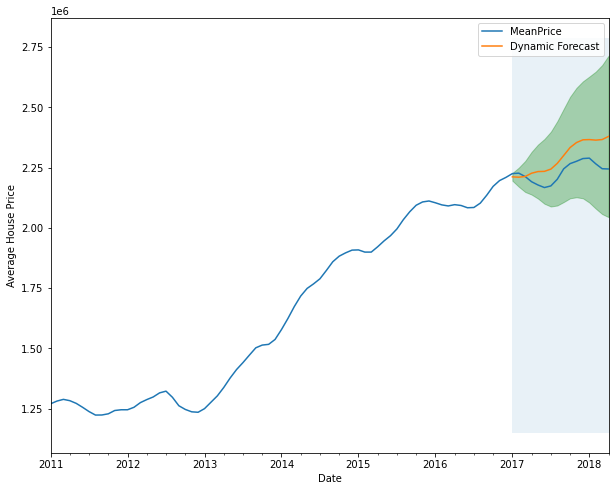

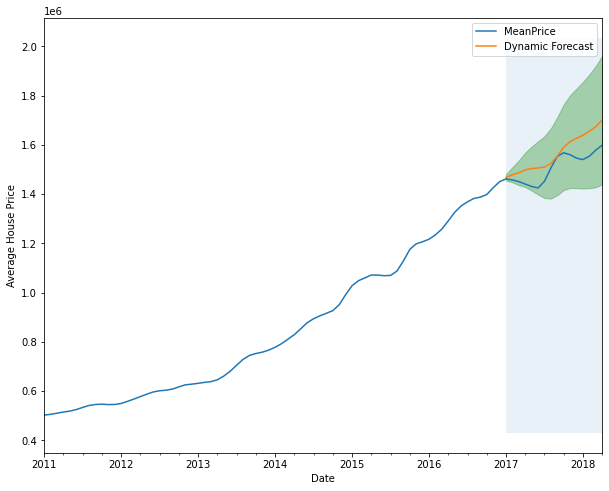

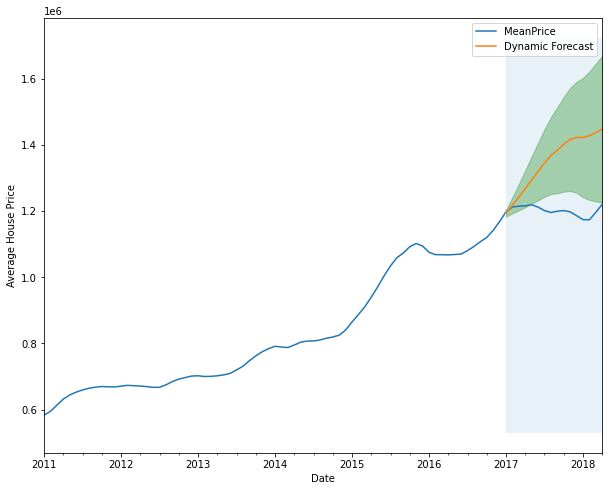

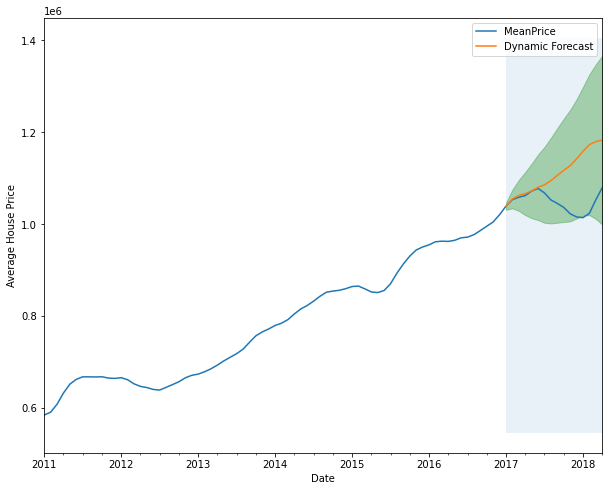

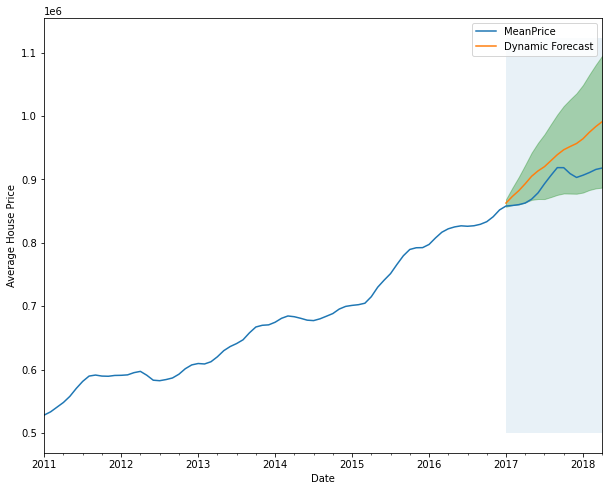

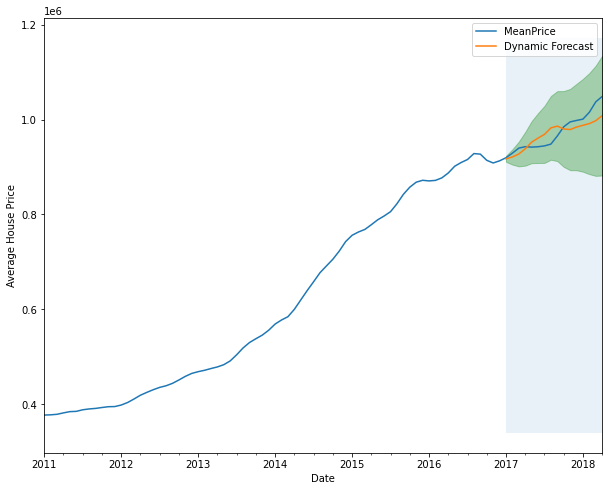

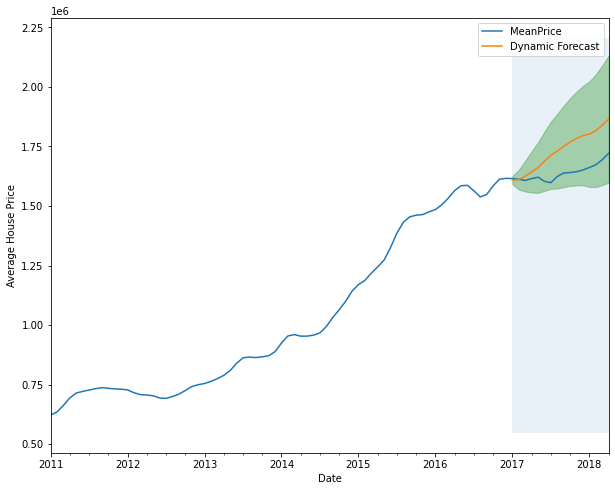

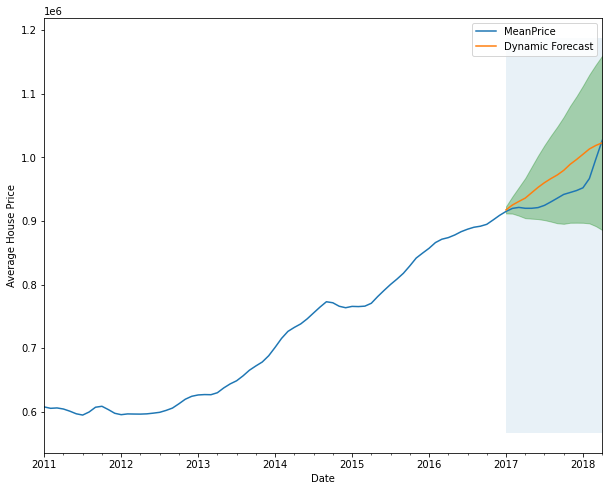

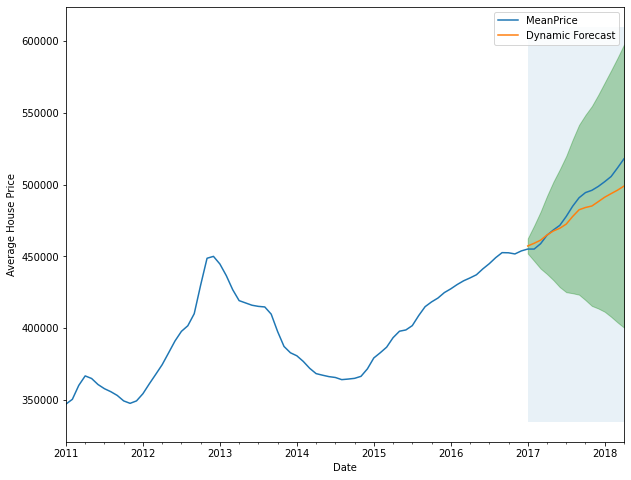

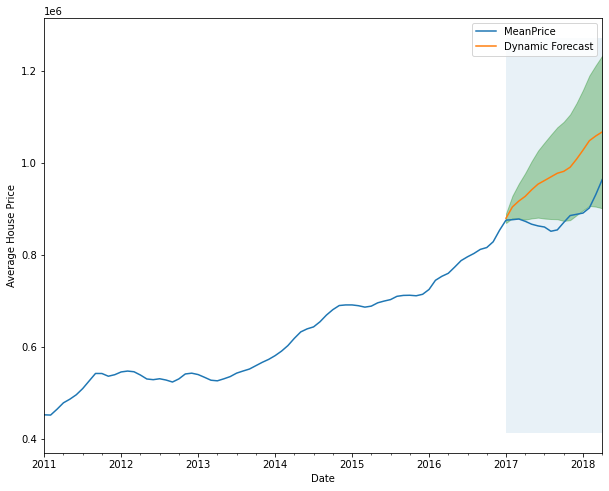

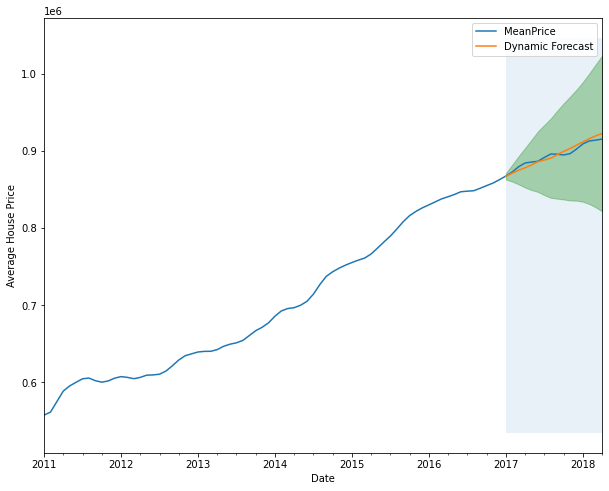

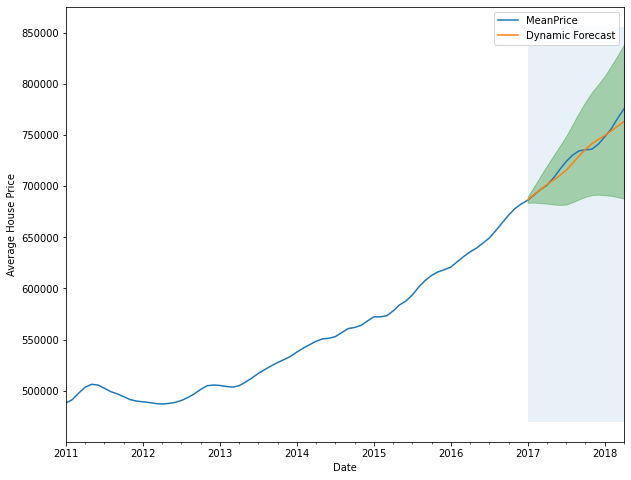

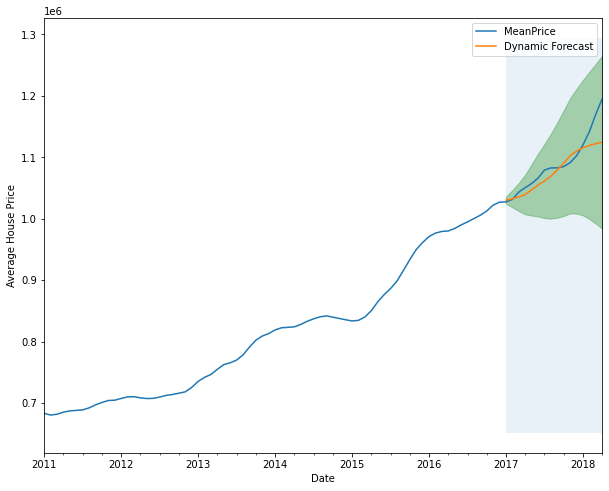

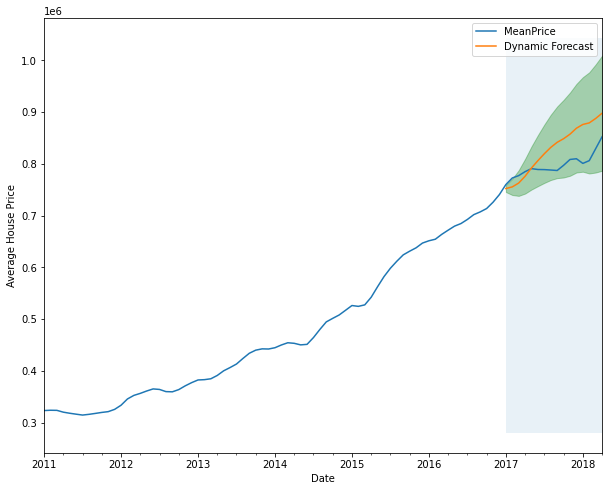

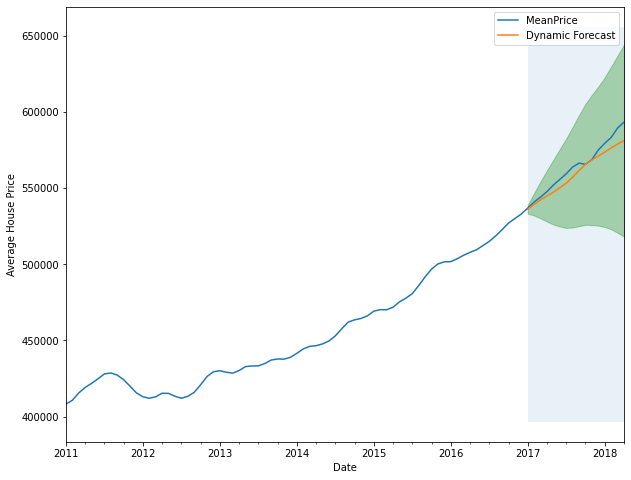

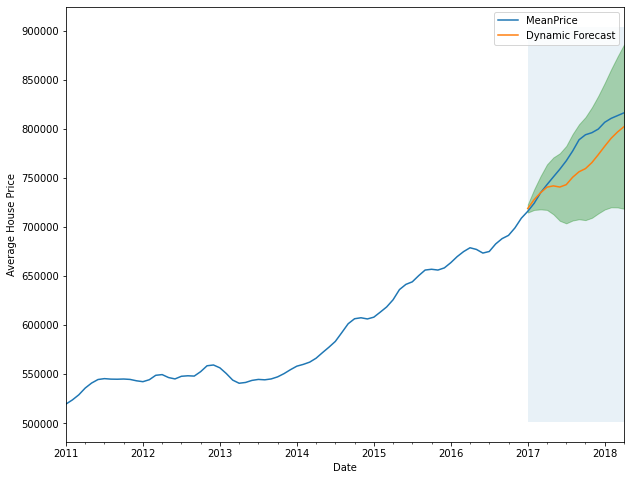

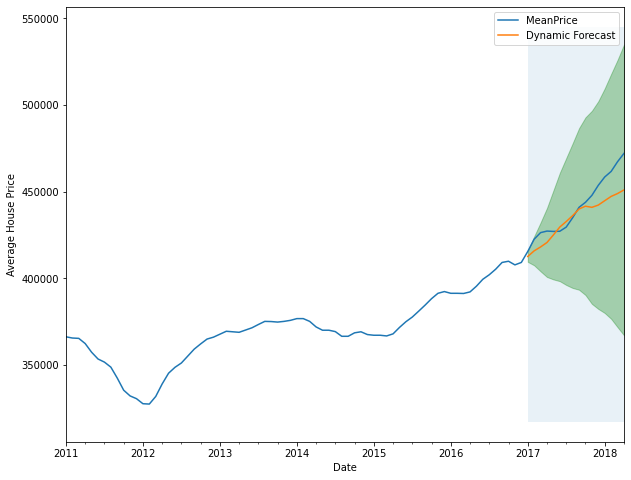

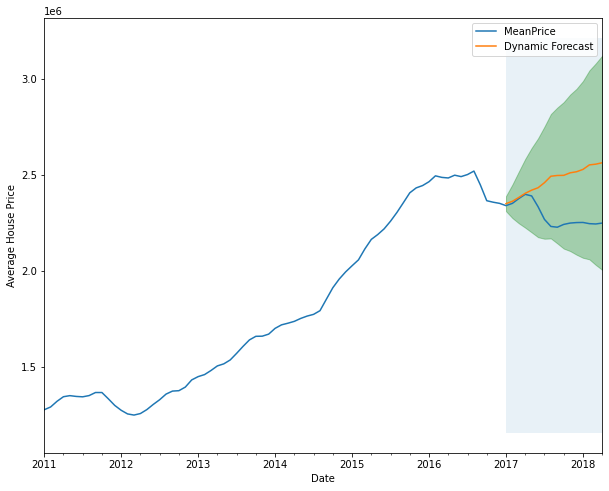

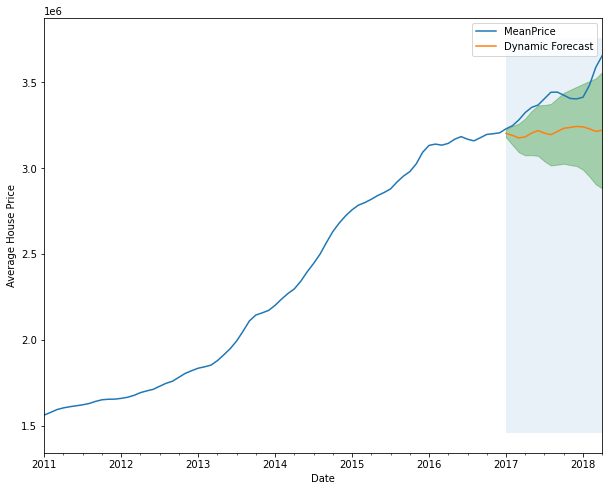

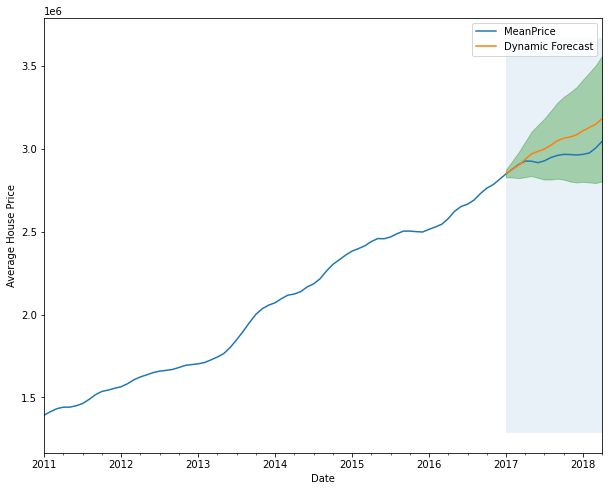

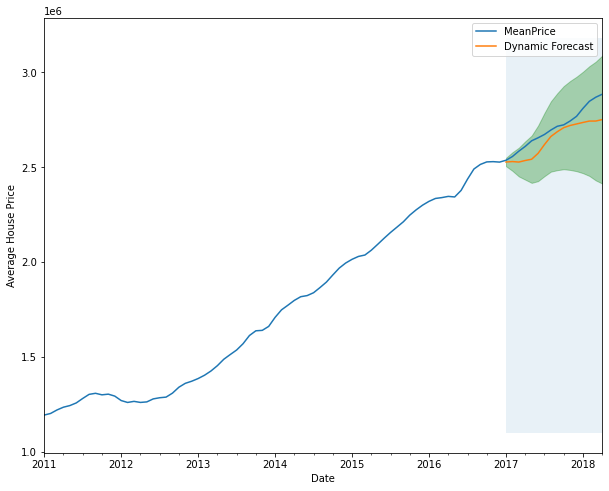

In [ ]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-01-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanPrice']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['RMSE'] = MSE_Value

In [ ]:
#Get the RMSE
summary_table.sort_values('RMSE').head()
#summary_table.head()

,Zipcode,RMSE
18,11224,4356.829606
6,11211,4697.786944
19,11226,5431.747756
22,11230,5749.393735
1,11204,6347.947720


In [ ]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanPrice'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,11203,489900.0,6.746460e+05,7.925614e+05,487226.371647,8.620656e+05,423019.721782,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
1,11204,976400.0,1.173452e+06,1.305639e+06,923829.478873,1.423075e+06,810340.899107,1.800937e+06,0.201815,0.337197,-0.053841,0.457471,-0.170073,0.844467
2,11205,450600.0,5.796279e+05,6.630006e+05,287982.718067,8.712730e+05,107890.111779,1.218111e+06,0.286347,0.471373,-0.360891,0.933584,-0.760563,1.703309
3,11208,1015800.0,1.051716e+06,1.081514e+06,738734.560023,1.364697e+06,479052.537698,1.683976e+06,0.035357,0.064692,-0.272756,0.343471,-0.528399,0.657783
4,11209,819600.0,9.873563e+05,1.104900e+06,659887.055686,1.314826e+06,465565.192978,1.744234e+06,0.204681,0.348096,-0.194867,0.604228,-0.431960,1.128153


#### Top 5 Zip codes with Highest 3Yr-ROI

In [ ]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
15,11221,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
20,11228,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
17,11223,963200.0,1.396041e+06,1.669053e+06,9.990354e+05,1.793046e+06,9.218192e+05,2.416287e+06,0.449378,0.732821,0.037205,0.861551,-0.042962,1.508604
21,11229,852300.0,1.182264e+06,1.389166e+06,9.238457e+05,1.440683e+06,8.969124e+05,1.881419e+06,0.387146,0.629903,0.083944,0.690347,0.052344,1.207462
0,11203,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123


#### Top 5 Zip codes with Highest 5Yr-ROI

In [ ]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
15,11221,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
20,11228,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
17,11223,963200.0,1.396041e+06,1.669053e+06,9.990354e+05,1.793046e+06,9.218192e+05,2.416287e+06,0.449378,0.732821,0.037205,0.861551,-0.042962,1.508604
21,11229,852300.0,1.182264e+06,1.389166e+06,9.238457e+05,1.440683e+06,8.969124e+05,1.881419e+06,0.387146,0.629903,0.083944,0.690347,0.052344,1.207462
0,11203,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123


## Step 5: Interpret the Results

Based on 3 year return on investment and 5 year return on investment, below 3 zipcodes stand out to be best area to invest in. 11221 and 11228 have a guaranteed positive ROI and could be as high as 87% in 3 years and 154% in 5 years. 
</N>
- 11221: 3Yr ROI: 17%-87%; 5Yr ROI: 16%-154%
- 11228: 3Yr ROI: 16%-78%; 5Yr ROI: 17%-140%
- 11223: 3Yr ROI: 3%-86%; 5Yr ROI: -4%-150%)
<br><br>
However, other factors need to be taken into consideration due to the limit of the time series models, such as transportation, public safety, number of new constructions in the area, and school district etc.